In [1]:
import tsl
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy
from torch_geometric.nn import MessagePassing
from einops import rearrange
plt.style.use('bmh')

# Air quality forecasting with spatiotemporal graph neural networks (STGNNs)

We use Torch Spatiotemporal ([tsl](https://torch-spatiotemporal.readthedocs.io/en/latest/#)), a Python library for neural spatiotemporal data processing that focuses on GNNs based on PyTorch, PyG and Torch Lightning. 

The library offers a variety of utilities, such as: 

- Classes to build custom datasets and data modules for training on them.
- Ways to deal with missing data.
- Preprocessing utilities such as scalers.
- Useful models and layers for both temporal and spatiotemporal data.
- Datasets from the literature. 
- Predictors extending the torch lightning modules, for training and inference. 


This notebook took inspiration from the official tsl tutorial "A Gentle Introduction to tsl".

In [2]:
from tsl.datasets import AirQuality
dataset = AirQuality(root='./data', small=True, impute_nans=True, )

[neptune] [warning] NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.



#### Spatiotemporal graphs

A **spatiotemporal** graph, models multivariate time series as a sequence of attributed graphs. Nodes contain the value of the time series at discretized time steps, while edges model the structural information between the variables. 

With this setting, graph neural networks and message passing
allow us to exploit the dependencies that exist across time series, modeled by the edges of the
graphs, with a single model sharing weights for all time series. 

Formally, a spatiotemporal graph for $N$ time series is defined as $\mathcal{G}=\{\mathcal{G}_1, \dots, \mathcal{G}_T\}$ where $\mathcal{G}_t=(X_t,A_t)$.

This setting can be extended to permit exogenous variables, missing values, and static attributes for nodesto be present by adding having:

$$
\mathcal{G}_t=\{X_t, A_t, M_t, U_t, V\}
$$

where $V\in \mathbb{R}^{N\times d_x}$ are he static variables, $M_t \in \mathbb{R}^{N\times d_x}$ is a mask for missing values for each node and each feature, and $U_t\in \mathbb{R}^{N\times d_u}$ are the exogenous variables. 

<p align="center">
  <img src="./imgs/temporal_graph.png" alt="temp_graph" width="600"/>
</p>

<p align="center">
  <img src="./imgs/temporal_graph_timeseries.png" alt="timeseries" width="600"/>
</p>

The connectivity can be:

- Known a priori.
- Inferred by means of similarity between the time series, physical proximity of the sensors, ...
- Learned alongside the downstream task.

*Sources: "A Survey on Graph Neural Networks for Time Series: Forecasting, Classification, Imputation, and Anomaly Detection" (Jin et al, 2024), "Graph Deep Learning for Time Series Forecasting" (Cini et. al, 2023)*

In [3]:
# The graph is not given a priori, however we can access some similarity metric between the nodes
print(f"We have the following similarity options: {dataset.similarity_options}")
sim = dataset.get_similarity("distance")

We have the following similarity options: {'distance'}


In [4]:
dataset.covariates.keys()

dict_keys(['dist', 'eval_mask'])

In [5]:
connectivity = dataset.get_connectivity(method='distance',
                                        threshold=0.1,
                                        include_self=False,
                                        layout="edge_index")

In [6]:
edge_index, edge_weight = connectivity 
edge_index, edge_weight = torch.tensor(edge_index), torch.tensor(edge_weight)

In [7]:
rad = .2
conn_style = f'arc3,rad={rad}'

def offset(d, pos, dist = rad/2, loop_shift = .2):
    for (u,v),obj in d.items():
        if u!=v:
            par = dist*(pos[v] - pos[u])
            dx,dy = par[1],-par[0]
            x,y = obj.get_position()
            obj.set_position((x+dx,y+dy))
        else:
            x,y = obj.get_position()
            obj.set_position((x,y+loop_shift))

def draw_graph(edge_index, edge_values=None):
        edge_list = edge_index.numpy().T.tolist()

        G = nx.MultiDiGraph()
        G.add_edges_from(edge_list)


        pos = nx.kamada_kawai_layout(G)


        nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
        nx.draw_networkx_labels(G, pos=pos, font_color='black', font_size=10)
        nx.draw_networkx_edges(G, pos=pos, edgelist=G.edges(), edge_color='black',
                        connectionstyle=conn_style)
        
        if edge_values is not None:
        # Draw edges with colors based on the starting node
                edge_value_list = edge_values.numpy().tolist() 
                edge_labels = {tuple(edge): f'{value:.2f}' for edge, value in zip(edge_list, edge_value_list)}
                d = nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, font_size=5)
                offset(d,pos)
        plt.gca().set_aspect('equal')

        plt.show()

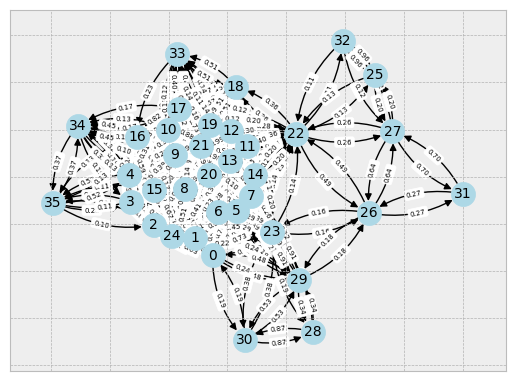

In [8]:
draw_graph(edge_index=edge_index, edge_values=edge_weight)

In [9]:
from tsl.data import SpatioTemporalDataset

# Parameters taken from https://arxiv.org/abs/2302.04071
window = 24
horizon = 3
torch_dataset = SpatioTemporalDataset(target=dataset.dataframe(),
                                      connectivity=connectivity,
                                      mask=dataset.mask,
                                      horizon=horizon,
                                      window=window,
                                      stride=1)
print(torch_dataset)
# Each sample generated with a sliding window as follows:
# |---------------x------------------------------------ ...  ------| <- time series
# |----input----|-delay-|---target---|              <- sample 1
# |-stride-|----input----|-delay-|---target---|     <- sample 2

# The sliding window has 24 time steps for the window and an horizon of 3 time steps
# to generate the input and target sequence respectively.
# Between input and target there can be a delay (default=0) and between consecutive samples there is 
# a stride (default=1)

SpatioTemporalDataset(n_samples=8733, n_nodes=36, n_channels=1)


In [10]:
sample = torch_dataset[0]
sample

Data(
  input=(x=[t=24, n=36, f=1], edge_index=[2, e=654], edge_weight=[e=654]),
  target=(y=[t=3, n=36, f=1]),
  has_mask=True
)

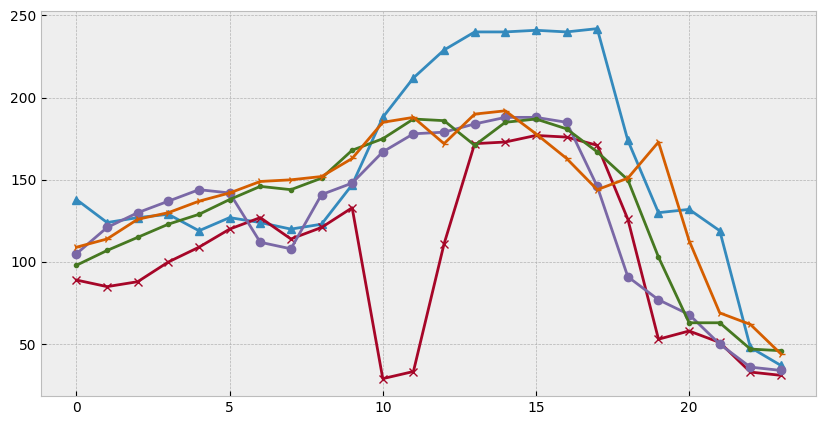

In [11]:
# Look at the data; there seem to be correlation.
# This is a good sign that GNNs can be helpful to forecast this process.
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sample.x[:,0], marker='^')
ax.plot(sample.x[:,1], marker='x')
ax.plot(sample.x[:,2], marker='o')
ax.plot(sample.x[:,3], marker='.')
ax.plot(sample.x[:,-1], marker='4')

In [12]:
from tsl.data.datamodule import (SpatioTemporalDataModule,
                                 TemporalSplitter)
from tsl.data.preprocessing import StandardScaler


scalers = {'target': StandardScaler(axis=(0, 1))}

# The dataset is split into train/val/test along the temporal axis: 
#   |-------- whole dataset ---------|
#   |--- train ---|- val -|-- test --|
splitter = TemporalSplitter(val_len=0.1, test_len=0.2)

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=splitter,
    batch_size=64,
)


In [13]:
dm.setup() # lazy

### Time-then-Space Models

These are models where there time and space are handled saparately. 

First, each time series is embedded into a vector:

$$h_t^i = \text{TemporalModel}(x_{\leq t}^i)$$

Then, information is propagated through space with a series of message-passing layers:

$$
H_t^{(l+1)} = \text{GNN}^{(l)}(H_t^l, A_t)
$$

*Sources: "Graph Deep Learning for Time Series Forecasting" (Cini et. al, 2023)*

In [14]:
import torch.nn as nn

from tsl.nn.models import RNNModel, GatedGraphNetworkModel, GraphWaveNetModel, VARModel
from tsl.nn.blocks.encoders import RNN
from tsl.nn.layers import NodeEmbedding, DiffConv
from einops.layers.torch import Rearrange  # reshape data with Einstein notation

# This model is taken from the "A Gentle Introduction to tsl" tutorial. 
# Below we define other models.
class TimeThenSpaceModel(nn.Module):
    def __init__(self, input_size: int, n_nodes: int, horizon: int,
                 hidden_size: int = 32,
                 rnn_layers: int = 1,
                 gnn_layers: int = 2):
        super(TimeThenSpaceModel, self).__init__()

        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size * horizon)

        self.node_embeddings = NodeEmbedding(n_nodes, hidden_size)

        self.time_model = RNN(input_size=hidden_size,
                            hidden_size=hidden_size,
                            n_layers=rnn_layers,
                            cell='gru',
                            return_only_last_state=True)

        self.space_model = DiffConv(in_channels=hidden_size,
                                    out_channels=hidden_size,
                                    k=gnn_layers)

        self.rearrange = Rearrange('b n (t f) -> b t n f', t=horizon)

    def forward(self, x, edge_index, edge_weight):
        x = self.encoder(x) 
        x = x + self.node_embeddings()  

        h = self.time_model(x) 
        z = self.space_model(h, edge_index, edge_weight)
        return self.rearrange(self.decoder(z))


### Space-then-Time Models

These models first propagate information in the spatial dimension for each time step, to obtain time series enhanced by the spatial relationships:

$$
H_t^{(l+1)} = \text{GNN}^{(l)}(H_t^l, A_t) \quad \forall t \in \{t-W, \dots, t\}
$$

Then, the resulting timeseries are processed by a sequence model: 

$$
h_t^i = \text{TemporalModel}(h_{t-W:t}^i)
$$

*Sources: "Graph Deep Learning for Time Series Forecasting" (Cini et. al, 2023)*

In [15]:
class SpaceThenTimeModel(nn.Module):
    def __init__(self, input_size: int, n_nodes: int, horizon: int,
                 hidden_size: int = 32,
                 rnn_layers: int = 1,
                 gnn_layers: int = 2):
        super(SpaceThenTimeModel, self).__init__()

        self.time_model = RNN(input_size=hidden_size,
                            hidden_size=hidden_size,
                            n_layers=rnn_layers,
                            cell='gru',
                            return_only_last_state=True)
        
        self.space_model = DiffConv(in_channels=hidden_size,
                                    out_channels=hidden_size,
                                    k=gnn_layers)
        
        self.node_embeddings = NodeEmbedding(n_nodes, hidden_size)
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size * horizon)
        self.rearrange = Rearrange('b n (t f) -> b t n f', t=horizon)

    def forward(self, x, edge_index, edge_weight):
        batch_size, win_size, num_nodes, num_feats = x.size()

        x = self.encoder(x)
        x = x + self.node_embeddings()

        x_enhanced = []
        for t in range(0, win_size):
            x_enhanced.append(self.space_model(x[:,t], edge_index, edge_weight))
        x_enhanced = torch.stack(x_enhanced, dim=1)

        h = self.time_model(x_enhanced) 
        return self.rearrange(self.decoder(h))

In [16]:
dummy_data = torch.randn(32,14,8,1)
ei = torch.tensor([[0, 1],[0,2],[0,3],[1,0],[1,2],[2,1],[2,0],[3,0]], dtype=torch.long).T
m = SpaceThenTimeModel(input_size=1, n_nodes=8, horizon=3, hidden_size=32, rnn_layers=2, gnn_layers=2)
m(dummy_data, edge_index=ei, edge_weight=None).shape

torch.Size([32, 3, 8, 1])

### Time-and-Space Models

The third category of STGNN does not have a clear separation between the processing of the temporal and spatial dimension.  

Examples include: 
- Temporal operators to compute messages, such as temporal convolutions (TCN):
$$ h_{t-W:t}^{i,(l+1)} = \text{TCN}_{\text{up}} \left( h_{t-W:t}^{i,(l)}, \text{Aggr} 
    \{ \text{TCN}_{\text{msg}} \left(h_{t-W:t}^{i,(l)},h_{t-W:t}^{j,(l)},e_{t-W:t}^{ij}\right); j\in \mathcal{N}_{t,i}\} \right)$$
- Interleave spatial convolution with temporal convolutions: 
$$
  \begin{aligned}
    z_{t-W:t}^{i,(l)} & = \text{TCN}^{(l)} \left(h_{t-W:t}^{i,(l-1)}\right) & \quad \forall i \\
    H_t^{(l)} & = \text{GNN}^{(l)} \left( Z_t^{(l)}, A_{t} \right) & \quad \forall t
  \end{aligned}
$$

- Use message-passing in models used for sequential data processing. For example, recurrent networks can use graph convolutions instead of vector-matrix multiplications. The vanilla RNN $h_t=\sigma (W_xx_t + W_hh_{t-1})$ would become:

$$
h_t^i = \sigma\left(\text{GNN}(x_t^i, A_t) + \text{GNN}(h_{t-1}^i, A_{t-1})\right)
$$

Below we find an example of  graph convolution recurrent networks.


*Sources: "Graph Deep Learning for Time Series Forecasting" (Cini et. al, 2023), "Structured Sequence Modeling with Graph Convolutional Recurrent Networks" (Seo et. al, 2016)*

In [17]:
# It may look complicated, but in the end it is a classic RNN, where instead of linear layers, GNN layers are used 
# to iterate over time. 
class GatedRecurrentGraphNetCell(MessagePassing):
    def __init__(self,
                 input_size: int,
                 state_size: int,
                 output_size: int,
                 skip_connection: bool = False):
        super(GatedRecurrentGraphNetCell, self).__init__(aggr="add")

        self.input_size = input_size
        self.state_size = state_size
        self.output_size = output_size
        self.skip_connection = skip_connection

        self.input_encoder = nn.Linear(input_size, state_size)
        self.state_encoder = nn.Linear(state_size, state_size)

        # Message network
        self.msg = nn.Sequential(
            nn.Linear(2*state_size, output_size),
            nn.ReLU(),
            nn.Linear(output_size, output_size),
            nn.ReLU()
        )
        # Gating network: Message -> [0,1]
        self.gate = nn.Sequential(
            nn.Linear(output_size, 1),
            nn.Sigmoid()
        )

        self.up = torch.nn.Sequential(
            nn.Linear(output_size+state_size, output_size),
            nn.ReLU(),
            nn.Linear(output_size, output_size),
            nn.ReLU() 
        )

        if skip_connection:
            if input_size != output_size:
                self.skip_conn = nn.Linear(input_size, output_size)
            else:
                self.skip_connection = nn.Identity()

    def forward(self, x, edge_index, h):

        # Handle the recurrence
        x_ = self.input_encoder(x) # d_in -> d_state
        h_ = self.state_encoder(h) # d_state -> d_state
        in_ = x_ + h_ 

        out = self.propagate(edge_index=edge_index, x=in_) 

        out = self.up(torch.cat([out, h], dim=-1)) 
        
        if self.skip_connection:
            out += self.skip_conn(x) 

        return out

    def message(self, x_i, x_j, edge_index):
        msg = self.msg(torch.cat([x_i,x_j], dim=-1)) 

        return self.gate(msg) * msg
    

class GatedRecurrentGraphNetModel(nn.Module):
    def __init__(self,
                 input_size,
                 state_size,
                 hidden_size,
                 horizon,
                 n_nodes,
                 n_layers=1,
                 skip_connection=True):
        super().__init__()


        self.input_size = input_size
        self.state_size = state_size
        self.hidden_size = hidden_size 
        self.n_layers = n_layers
        self.skip_connection = skip_connection
        self.horizon = horizon
        self.node_embeddings = NodeEmbedding(n_nodes, state_size)

        if state_size != hidden_size * n_layers:
            self.state_encoder = nn.Linear(state_size, hidden_size * n_layers)
            self.readout = nn.Linear(hidden_size * n_layers, state_size)
        else:
            self.state_encoder = nn.Identity()
            self.readout = nn.Identity()

        self.input_encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(state_size, input_size)
        self.rearrange = Rearrange('b n (t f) -> b t n f', t=horizon)

        self.gated_graph_conv_layers = nn.ModuleList(
            [
                GatedRecurrentGraphNetCell(input_size=hidden_size,
                                           state_size=hidden_size,
                                           output_size=hidden_size,
                                           skip_connection=False) 
                                           for _ in range(n_layers)
            ])
            
    def iterate_layers(self, x, h, **kwargs):
        output = []

        for l, layer in enumerate(self.gated_graph_conv_layers):
            x = x + layer(x=x, h=h[l], **kwargs)
            output.append(x)

        return torch.cat(output, dim=-1)
        
    def forward(self, x, edge_index=None):

        batch_size, win_size, num_nodes, num_feats = x.size()
        if edge_index is None:
            # Generate a full graph for dynamic graph learning

            nodes = torch.arange(num_nodes, device=x.device)
            edge_index = torch.cartesian_prod(nodes, nodes).T

        state = torch.zeros(batch_size, num_nodes, self.state_size, device=x.device)

        # iterate in time
        for t in range(0, win_size):
            
            # Encode input and state
            h_ = self.state_encoder(state + self.node_embeddings())
            x_ = self.input_encoder(x[:,t])

            h_ = rearrange(h_, "b n ... (h l) -> l b n ... h", l=self.n_layers)
            # Iterate in depth 
            h_new = self.iterate_layers(x=x_, h=h_, edge_index=edge_index)

            h_ = rearrange(h_, 'l b n ... h -> b n ... (h l)', l=self.n_layers)

            if self.skip_connection: 
                h_new = h_new + h_
                
            state =  self.readout(h_new) # [b, n, s]

        # forecast the horizon
        outputs = []
        for t in range(0, self.horizon):
            out_ = self.decoder(state)
            outputs.append(out_)

            h_ = self.state_encoder(state + self.node_embeddings())
            x_ = self.input_encoder(out_)
            h_ = rearrange(h_, "b n ... (h l) -> l b n ... h", l=self.n_layers)
            # Iterate in depth 
            h_new = self.iterate_layers(x=x_, h=h_, edge_index=edge_index)

            h_ = rearrange(h_, 'l b n ... h -> b n ... (h l)', l=self.n_layers)

            if self.skip_connection: 
                h_new = h_new + h_
                
            state  =  self.readout(h_new) # [b, n, s]

        return torch.stack(outputs, dim=1)
            
        

In [18]:
class GatedGraphNetCell(MessagePassing):
    def __init__(self,
                 input_size: int,
                 output_size: int,
                 skip_connection: bool = False):
        super(GatedGraphNetCell, self).__init__(aggr="add")

        self.input_size = input_size
        self.output_size = output_size
        self.skip_connection = skip_connection

        # Message network
        self.msg = nn.Sequential(
            nn.Linear(2*input_size, output_size),
            nn.Tanh(),
            nn.Linear(output_size, output_size), # output size here or still state size??
            nn.Tanh()
        )

        # Gating network: Message -> [0,1]
        self.gate = nn.Sequential(
            nn.Linear(output_size, 1),
            nn.Sigmoid()
        )

        self.up = torch.nn.Sequential(
            nn.Linear(output_size, output_size),
            nn.Tanh(),
            nn.Linear(output_size, output_size),
            nn.Tanh()
        )

        if skip_connection:
            if input_size != output_size:
                self.skip_conn = nn.Linear(input_size, output_size)
            else:
                self.skip_conn = nn.Identity()

    def forward(self, x, edge_index):
        out = self.propagate(edge_index=edge_index, x=x) 

        # Update should be moved in MessagePassing.Update?
        out = self.up(out)  
        
        if self.skip_connection:
            out += self.skip_conn(x)
        # maybe concat instead of +
        return out

    def message(self, x_i, x_j):
        msg = self.msg(torch.cat([x_i,x_j], dim=-1))

        # dynamically infer the graph topology based on the message
        return self.gate(msg) * msg
    
class Graph_sLSTM(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, horizon, n_nodes, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size

        self.node_embeddings = NodeEmbedding(n_nodes, hidden_size)

        self.w_i = GatedGraphNetCell(input_size=in_size, output_size=hidden_size)
        self.w_f = GatedGraphNetCell(input_size=in_size, output_size=hidden_size)
        self.w_o = GatedGraphNetCell(input_size=in_size, output_size=hidden_size)
        self.w_z = GatedGraphNetCell(input_size=in_size, output_size=hidden_size)

        self.r_i = GatedGraphNetCell(input_size=hidden_size, output_size=hidden_size)
        self.r_f = GatedGraphNetCell(input_size=hidden_size, output_size=hidden_size)
        self.r_o = GatedGraphNetCell(input_size=hidden_size, output_size=hidden_size)
        self.r_z = GatedGraphNetCell(input_size=hidden_size, output_size=hidden_size)

        self.decoder = nn.Linear(hidden_size, out_size * horizon)
        self.rearrange = Rearrange('b n (t f) -> b t n f', t=horizon)


    def forward(self, x, edge_index, stabilize=True):

        B,T,N,_ = x.shape
        h_tm1 = torch.zeros(B,N,self.hidden_size, device=x.device)
        n_tm1 = torch.zeros(B,N,self.hidden_size, device=x.device)
        c_tm1 = torch.zeros(B,N,self.hidden_size, device=x.device)
        m_tm1 = torch.zeros(B,N,self.hidden_size, device=x.device)

        for t in range(T):
            x_t = x[:,t,...]

            h_tm1 =h_tm1 + self.node_embeddings()

            tilde_i_t = self.w_i(x=x_t,edge_index=edge_index) + self.r_i(x=h_tm1, edge_index=edge_index)
            tilde_f_t = self.w_f(x=x_t,edge_index=edge_index) + self.r_f(x=h_tm1, edge_index=edge_index)
            tilde_o_t = self.w_o(x=x_t,edge_index=edge_index) + self.r_o(x=h_tm1, edge_index=edge_index)
            tilde_z_t = self.w_z(x=x_t,edge_index=edge_index) + self.r_z(x=h_tm1, edge_index=edge_index)


            #
            z_t = torch.nn.functional.tanh(tilde_z_t)
            i_t = torch.exp(tilde_i_t)
            f_t = torch.exp(tilde_f_t)
            o_t = torch.nn.functional.sigmoid(tilde_o_t)
            
            if stabilize:
                m_t = torch.max(torch.log(f_t) + m_tm1, torch.log(i_t))
                i_t = torch.exp(tilde_i_t - m_t)
                f_t = torch.exp(torch.log(f_t) + m_tm1 - m_t)

            c_t = f_t * c_tm1 + i_t * z_t
            n_t = f_t * n_tm1 + i_t
            tilde_h = c_t / n_t
            h_t = o_t * tilde_h

            h_tm1, n_tm1, c_tm1, m_tm1 = h_t, n_t, c_t, m_t if stabilize else m_tm1

        return self.rearrange(self.decoder(h_tm1))

In [19]:
hidden_size = 64   
rnn_layers = 2     
gnn_layers = 2    

input_size = torch_dataset.n_channels   # 1 channel
n_nodes = torch_dataset.n_nodes         # 36 nodes
horizon = torch_dataset.horizon         # 3 time steps

type = 'graph_wave_net'

def get_model(type):
    if type == 'tts':
        return TimeThenSpaceModel(input_size=input_size,
                                n_nodes=n_nodes,
                                horizon=horizon,
                                hidden_size=hidden_size,
                                rnn_layers=rnn_layers,
                                gnn_layers=gnn_layers)
    elif type == 'stt':
        return SpaceThenTimeModel(input_size=input_size, n_nodes=n_nodes,
                                  horizon=horizon, hidden_size=hidden_size,
                                  rnn_layers=rnn_layers, gnn_layers=gnn_layers)
    elif type == 'rnn':
        return RNNModel(input_size=input_size, 
                        output_size=input_size, 
                        horizon=horizon, 
                        hidden_size=hidden_size, 
                        rec_layers=rnn_layers, 
                        cell_type='gru')
    elif type == 'gated':
        return GatedGraphNetworkModel(input_size=input_size, input_window_size=window,
                                      horizon=horizon, n_nodes=n_nodes, hidden_size=hidden_size,
                                      output_size=input_size, gnn_layers=gnn_layers,full_graph=False,
                                      enc_layers=rnn_layers)
    elif type == 'gated_recurrent':
        return GatedRecurrentGraphNetModel(input_size=1, state_size=hidden_size,
                                           hidden_size=hidden_size,
                                           n_layers=2, skip_connection=True,
                                           n_nodes=n_nodes,
                                           horizon=horizon)
    elif type == 'graph_wave_net':
        return GraphWaveNetModel(input_size=input_size, output_size=input_size,
                                 horizon=horizon, hidden_size=32, ff_size=256,n_layers=6,
                                 temporal_kernel_size=3, spatial_kernel_size=2, dilation=2, dilation_mod=3, n_nodes=n_nodes)
    elif type == 'graph_sLSTM':
        return Graph_sLSTM(in_size=input_size, hidden_size=hidden_size, out_size=input_size, horizon=horizon, n_nodes=n_nodes)
    elif type == 'var':
        return VARModel(input_size=input_size, n_nodes=n_nodes, temporal_order=window, output_size=1, horizon=horizon)
    else:
        raise NotImplementedError()
    
stgnn = get_model(type=type)
print(stgnn)

GraphWaveNetModel(
  (source_embeddings): NodeEmbedding(n_nodes=36, embedding_size=10)
  (target_embeddings): NodeEmbedding(n_nodes=36, embedding_size=10)
  (input_encoder): Linear(in_features=1, out_features=32, bias=True)
  (tconvs): ModuleList(
    (0): TemporalConvNet(
      (convs): ModuleList(
        (0): GatedTemporalConv(
          (pad_layer): ZeroPad2d((0, 0, 0, 0))
          (conv): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1))
        )
      )
      (f): Identity()
      (dropout): Identity()
    )
    (1): TemporalConvNet(
      (convs): ModuleList(
        (0): GatedTemporalConv(
          (pad_layer): ZeroPad2d((0, 0, 0, 0))
          (conv): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1), dilation=(1, 2))
        )
      )
      (f): Identity()
      (dropout): Identity()
    )
    (2): TemporalConvNet(
      (convs): ModuleList(
        (0): GatedTemporalConv(
          (pad_layer): ZeroPad2d((0, 0, 0, 0))
          (conv): Conv2d(32, 64, kernel_size=(1, 3), st

In [20]:
from tsl.metrics.torch import MaskedMAE, MaskedMAPE, MaskedMSE
from tsl.engines import Predictor

loss_fn = MaskedMAPE()

metrics = {'mae': MaskedMAE(),
           'mape': MaskedMAPE(),
           'mae_at_2': MaskedMAE(at=1),  
           'mae_at_3': MaskedMAE(at=2)} # '2' indicates the third time step, hence 3h ahead

# setup predictor
max_epochs = 100

predictor = Predictor(
    model=stgnn,                  
    optim_class=torch.optim.Adam,
    optim_kwargs={'lr': 0.001},
    loss_fn=loss_fn,
    metrics=metrics,
    scheduler_class=torch.optim.lr_scheduler.CosineAnnealingLR,
    scheduler_kwargs={'eta_min': 0.0001, 'T_max': max_epochs}
)


In [21]:
from pytorch_lightning.loggers import TensorBoardLogger
import datetime
run_name = f'run_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_{type}'

logger = TensorBoardLogger(save_dir="logs", name=run_name, version=0)

In [23]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1961), started 0:00:02 ago. (Use '!kill 1961' to kill it.)

In [24]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging

checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1,
    monitor='val_mae',
    mode='min',
)

# swa_callback = StochasticWeightAveraging(swa_lrs=1e-2)

trainer = pl.Trainer(max_epochs=max_epochs,
                     logger=logger,
                     gpus=1 if torch.cuda.is_available() else None,
                    #  limit_train_batches=100,  # end an epoch after 100 updates
                     callbacks=[checkpoint_callback],
                     gradient_clip_val=1.0,
                     gradient_clip_algorithm="norm")

trainer.fit(predictor, datamodule=dm)

/home/michele/anaconda3/envs/gkf-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/michele/anaconda3/envs/gkf-env/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/michele/ML_stuff/Graph-Neural-Networks-Tutorial/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | loss_fn       | MaskedMAPE        | 0     
1 | train_metrics | 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/michele/anaconda3/envs/gkf-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Only args ['edge_weight', 'edge_index', 'x'] are forwarded to the model (GraphWaveNetModel). 
/home/michele/anaconda3/envs/gkf-env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


/home/michele/anaconda3/envs/gkf-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 99: 100%|██████████| 108/108 [00:07<00:00, 15.28it/s, loss=0.231, v_num=0, val_mae=20.20, val_mae_at_2=20.70, val_mae_at_3=26.20, val_mape=0.342, train_mae=13.10, train_mae_at_2=13.40, train_mae_at_3=16.10, train_mape=0.227]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 108/108 [00:07<00:00, 15.27it/s, loss=0.231, v_num=0, val_mae=20.20, val_mae_at_2=20.70, val_mae_at_3=26.20, val_mape=0.342, train_mae=13.10, train_mae_at_2=13.40, train_mae_at_3=16.10, train_mape=0.227]


In [25]:
# Get best model (before overfitting)

predictor.load_model(checkpoint_callback.best_model_path)
predictor.freeze()

trainer.test(predictor, datamodule=dm)

Predictor with already instantiated model is loading a state_dict from /home/michele/ML_stuff/Graph-Neural-Networks-Tutorial/logs/epoch=66-step=6499.ckpt. Cannot  check if model hyperparameters are the same.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/michele/anaconda3/envs/gkf-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 28/28 [00:01<00:00, 25.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3357805907726288
        test_mae            18.596046447753906
      test_mae_at_2          19.0345401763916
      test_mae_at_3         24.313323974609375
        test_mape           0.3319031894207001
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_mae': 18.596046447753906,
  'test_mae_at_2': 19.0345401763916,
  'test_mae_at_3': 24.313323974609375,
  'test_mape': 0.3319031894207001,
  'test_loss': 0.3357805907726288}]

In [26]:
test_batch = next(iter(dm.get_dataloader(split='test')))

In [27]:
y, y_hat, mask = predictor.predict_batch(test_batch, postprocess=True, return_target=True)

In [28]:
batch_elem = 0
node_to_plot = 1


In [29]:
def plot_window_and_forecast(test_batch, batch_elem, nodes_to_plot):
    x_coords = torch.arange(0, window)
    y_coords = torch.arange(window, window+horizon)

    x_to_plot = test_batch.input.x
    x_to_plot = test_batch.transform['x'].inverse_transform(x_to_plot)

    fig, ax = plt.subplots(figsize=(10, 3))
    for node in nodes_to_plot: 
        x_to_plot_ = x_to_plot[batch_elem, :, node]

        y_to_plot = y[batch_elem, :, node]

        y_hat_to_plot = y_hat[batch_elem, :, node]

        ax.plot(x_coords, x_to_plot_, marker='^', label=r"$x_{node}$".replace('node', str(node)))
        y_line = ax.plot(y_coords, y_to_plot, marker='x', label=r"$y_{node}$".replace('node', str(node)))
        ax.plot(y_coords, y_hat_to_plot, marker='.', label=r"$\hat y_{node}$".replace('node', str(node)), color=y_line[0].get_color())
        ax.plot([x_coords[-1],y_coords[0]], [x_to_plot_[-1], y_to_plot[0].item()], '--', color='grey')
        ax.plot([x_coords[-1],y_coords[0]], [x_to_plot_[-1], y_hat_to_plot[0].item()], '-', color='grey')
        # ax.legend()
        ax.legend(loc=(1.04, 0))
        fig.tight_layout()

/home/michele/anaconda3/envs/gkf-env/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


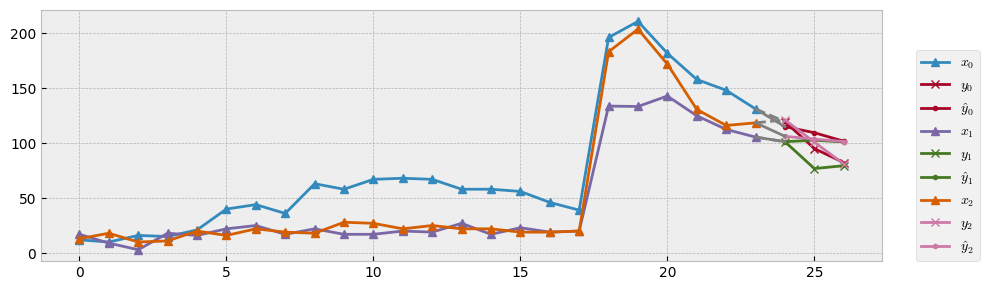

In [30]:
plot_window_and_forecast(test_batch=test_batch,
                         batch_elem=12,
                         nodes_to_plot=[0,1,2])

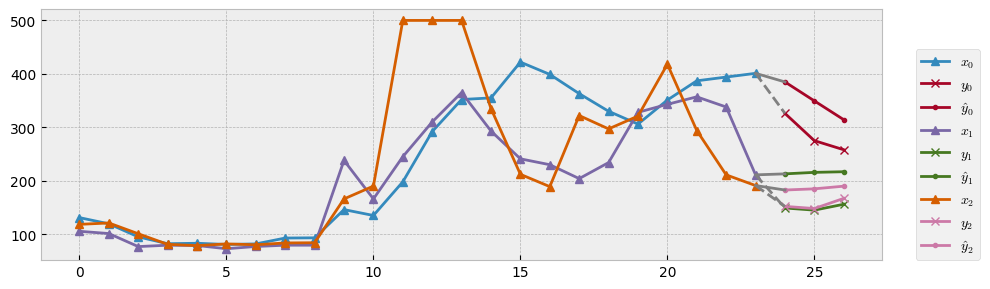

In [31]:
plot_window_and_forecast(test_batch=test_batch,
                         batch_elem=-5,
                         nodes_to_plot=[0,1,2])

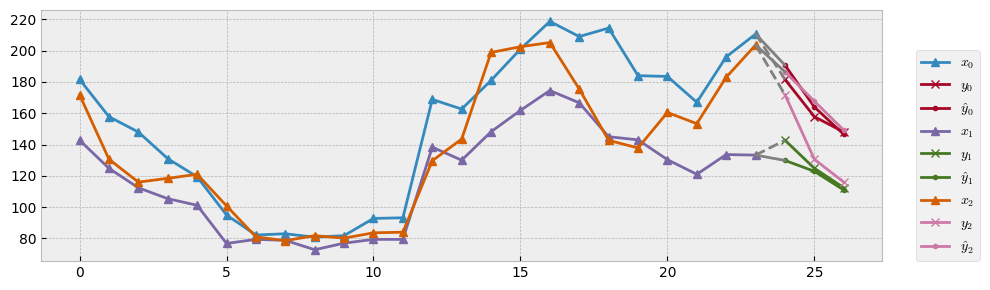

In [33]:
plot_window_and_forecast(test_batch=test_batch,
                         batch_elem=32,
                         nodes_to_plot=[0,1,2])